# *wtie*: Introduction to the package
In this tutorial we work on data from the Well *Torosa1* of the open [Poseidon](https://terranubis.com/datainfo/NW-Shelf-Australia-Poseidon-3D) dataset. Data is saved in the folder **data/tutorial**.

### Load packages

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import yaml
from pprint import pprint

from wtie import grid, viz, tie
from wtie.utils.datasets import tutorial

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

### Load data

In [2]:
# data path
folder = Path('../data/tutorial')

# inputs is a class that stores the useful input data to perform a well tie
inputs = tutorial.load_poseidon_data(folder) 

In [3]:
pprint(inputs.__dict__)

{'logset_md': <wtie.processing.grid.LogSet object at 0x7fb7f039bc10>,
 'seismic': <wtie.processing.grid.Seismic object at 0x7fb7effc9390>,
 'table': <wtie.processing.grid.TimeDepthTable object at 0x7fb7f0120ed0>,
 'wellpath': <wtie.processing.grid.WellPath object at 0x7fb7eff7fb10>}


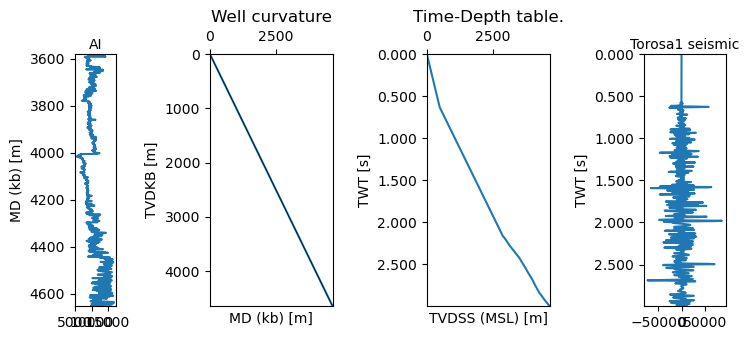

In [4]:
inputs.plot_inputs(figsize=(7.5,3.5));

### Load neural network to perform wavelet extraction

In [5]:
# neural network's pre-trained weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from ../data/tutorial/trained_net_state_dict.pt


### Filter the well logs

(<Figure size 600x500 with 3 Axes>,
 array([<AxesSubplot:xlabel='Vp [km/s]', ylabel='MD (kb) [m]'>,
        <AxesSubplot:xlabel='Vs [km/s]'>,
        <AxesSubplot:xlabel='Rho [g/cm³]'>], dtype=object))

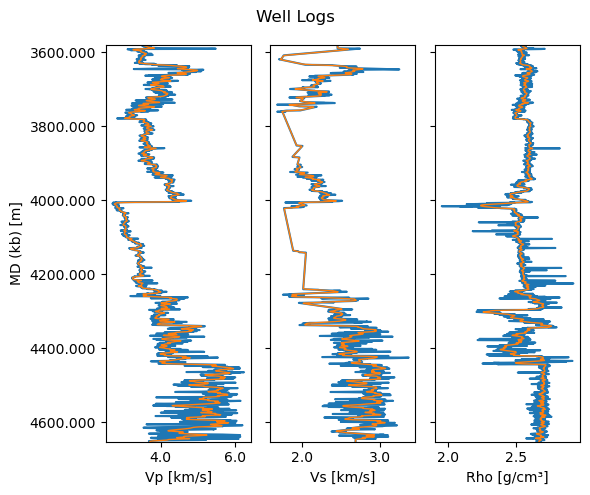

In [6]:
filtered_logset_md = tie.filter_md_logs(inputs.logset_md,
                                        median_size=21, threshold=2.0, std=2.0,std2=None)

viz.plot_logsets_overlay(inputs.logset_md, filtered_logset_md, figsize=(6,5))

### Depth to time convertion

/home/caio/Code/L3C/dlseis_well_tie/wtie/processing/grid.py:1209: UserWarning:

Truncating log as the well path information does not reach                      the maximum depth.



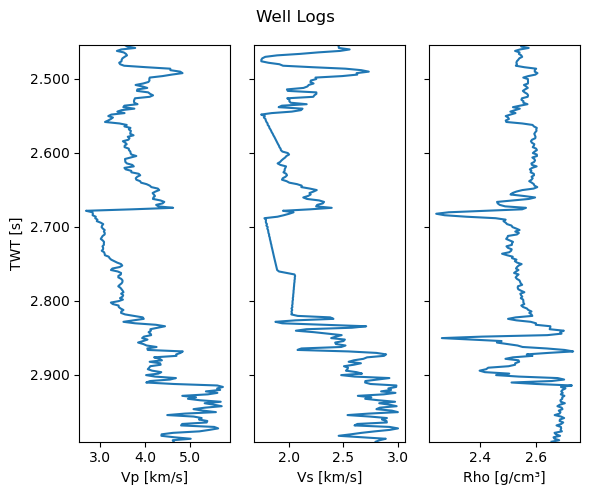

In [7]:
logset_twt = tie.convert_logs_from_md_to_twt(filtered_logset_md,
                                             inputs.wellpath,
                                             inputs.table,
                                             dt=wavelet_extractor.expected_sampling)
viz.plot_logset(logset_twt, figsize=(6,5));

(2.454575966403682, 2.990575966403861)

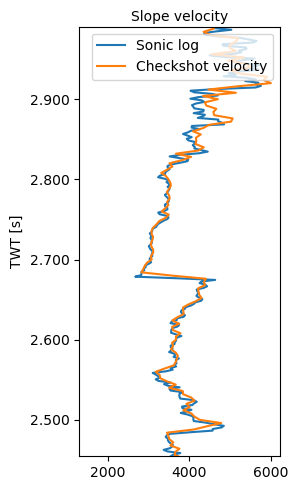

In [8]:
#compute velocities from Vp and checkshot tables
fig,ax = viz.plot_trace(logset_twt.Vp, plot_params=dict(label='Sonic log'))
viz.plot_trace(inputs.table.slope_velocity_twt(), fig_axes=(fig,ax), plot_params=dict(label='Checkshot velocity'))
ax.legend(loc='best')
ax.set_ylim((logset_twt.Vp.basis[0], logset_twt.Vp.basis[-1]))

### Compute vertical incidence relfectivity

(<Figure size 300x500 with 1 Axes>,
 <AxesSubplot:xlabel='R0', ylabel='TWT [s]'>)

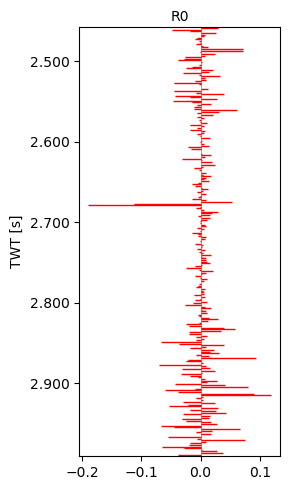

In [9]:
r0 = tie.compute_reflectivity(logset_twt)
viz.plot_reflectivity(r0)

### Interpolate seismic and find intersection with reflectivity

TWT [s]
0.000       -0.000000
0.004       -0.000000
0.008       -0.000000
0.012       -0.000000
0.016       -0.000000
             ...     
2.980      569.694092
2.984   -10828.234375
2.988    -7597.718750
2.992    11027.179688
2.996    11266.875000
Name: Torosa1 seismic, Length: 750, dtype: float32
TWT [s]
0.000    1.280694e-11
0.002    3.362710e+00
0.004   -4.787512e-12
0.006   -3.371631e+00
0.008    1.396533e-11
             ...     
2.986   -1.236100e+04
2.988   -7.597719e+03
2.990    1.912573e+03
2.992    1.102718e+04
2.994    1.455108e+04
Name: Torosa1 seismic, Length: 1498, dtype: float64


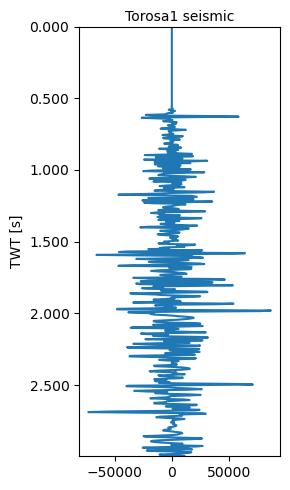

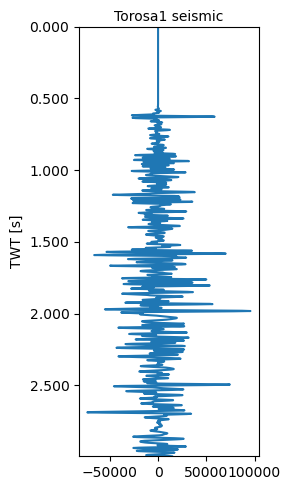

In [10]:
viz.plot_trace(inputs.seismic)
seismic_sinc = tie.resample_seismic(inputs.seismic, wavelet_extractor.expected_sampling)
print(inputs.seismic)
print(seismic_sinc)
viz.plot_trace(seismic_sinc)
seis_match, r0_match = tie.match_seismic_and_reflectivity(seismic_sinc, r0)

(<Figure size 300x500 with 1 Axes>,
 <AxesSubplot:xlabel='Real seismic and reflectivity', ylabel='TWT [s]'>)

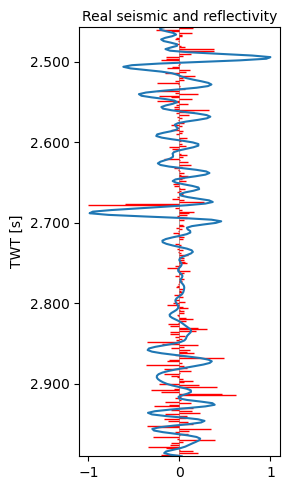

In [11]:
viz.plot_seismic_and_reflectivity(seis_match, r0_match, normalize=True, title='Real seismic and reflectivity')

### Compute seismic wavelet

In [12]:
from wtie.optimize.wavelet import compute_expected_wavelet

(-90.0, 5.0)

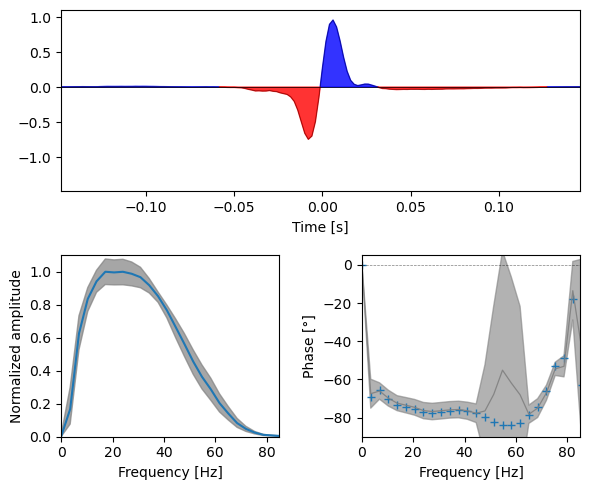

In [13]:
pred_wlt = compute_expected_wavelet(evaluator=wavelet_extractor,
                                    seismic=seis_match,
                                    reflectivity=r0_match)
fig, axes = viz.plot_wavelet(pred_wlt, figsize=(6,5), fmax = 85, phi_max = 100)
axes[2].set_ylim((-90,5))

### Compute synthetic seismic

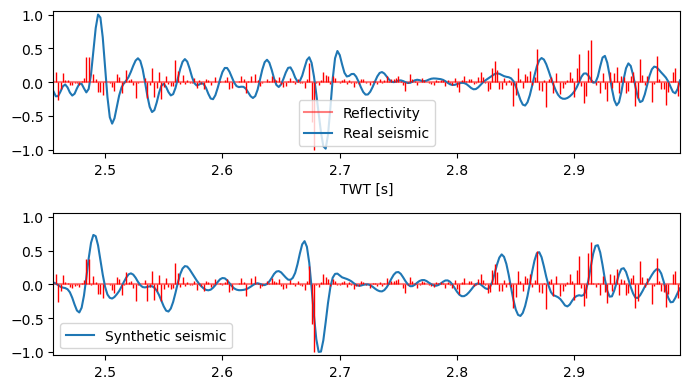

In [14]:
modeler = tutorial.get_modeling_tool()

synth_seismic = tie.compute_synthetic_seismic(modeler, pred_wlt, r0_match)
viz.plot_seismics(seis_match,
                  synth_seismic,
                  r0_match);

### Similarity between real and synthetic seismic

In [15]:
from wtie.optimize import similarity

xcorr = similarity.traces_normalized_xcorr(seis_match, synth_seismic)
xcorr = grid.upsample_trace(xcorr, 0.001)
dxcorr = similarity.dynamic_normalized_xcorr(seis_match, synth_seismic)
print("Max coeff of %.2f at a lag of %.3f sec" % (xcorr.R, xcorr.lag))

Max coeff of 0.78 at a lag of 0.002 sec


### Visualize results

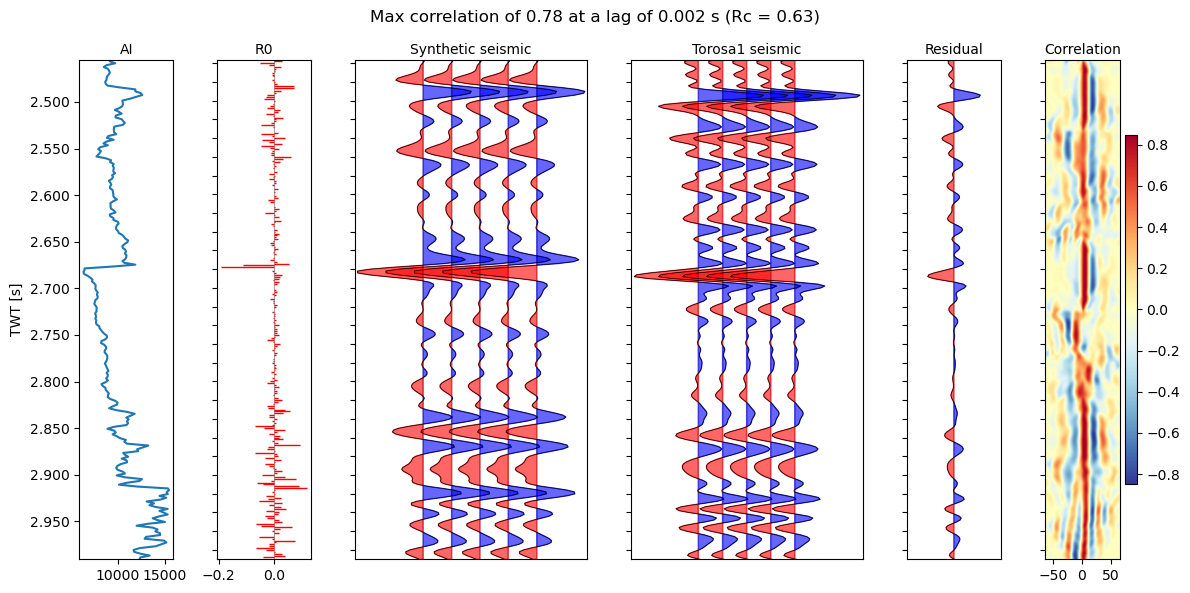

In [16]:
fig, axes = viz.plot_tie_window(logset_twt,
                    r0_match,
                    synth_seismic,
                    seis_match,
                    xcorr,
                    dxcorr,
                    figsize=(12,6),
                    wiggle_scale_syn=0.5,
                    wiggle_scale_real=110000
                    ) 
axes[0].locator_params(axis='y', nbins=16)
fig.tight_layout()